In [31]:
using Pkg; Pkg.activate("."); 
using PyPlot
using MUST
using DelimitedFiles
using LaTeXStrings
using Printf

MUST.@get_help visual
MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2/";

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/initial_conditions/Project.toml`


# Target properties of the model

In [32]:
Teff = 5777.0
logg = log(2.75e4);

The corresponding model we want to compare it to

In [33]:
path  = MUST.@in_dispatch("input_data/solar_stagger_ext")
path  = abspath.("../stagger2bifrost/stagger_av.dat")
model = reverse(readdlm(path, skipstart=2), dims=1)
z_goal, T_goal, d_goal = model[:, 1], model[:, 2], exp.(model[:, 3]);

The corresponding box dimensions based on the scale height

In [34]:
MUST.box_dimensions(Teff, exp(logg))

Dict{Symbol, Float64} with 2 entries:
  :z => 4.0299
  :x => 1.49682

EoS + Opacities

In [35]:
#eos_path = "input_data/LegacyStagger_sun"
eos_path = "input_data/TSO_sun_Magg_v10.2"
eos_path = "input_data/DIS_AESOPUS_v1.3.3"
eos_path = "input_data/DIS_MARCS_v0.3.1"
eos_path = "input_data/DISSTAG_v0.1"

eos = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

# 1. Investigate the Adiabats

In [36]:
#-6.545
#10300
#-0.15

#=
T_ini = [11000, 11000, 13000, 13000]
ρ_ini = [exp10(-6.2),  exp10(-6.), exp10(-6.2), exp10(-6.0)]
z0    = [-0.15, -0.15, -0.15, -0.15]
=#

In [37]:
T_ini = [11500, 11500, 11500]
ρ_ini = [3e-7,3e-7,3e-7]
z0    = [-0.2,-0.2,-0.2]
z0    = [MUST.geometrical_depth(d_goal, ρ_ini[i], z_goal) / 1e8 for i in eachindex(T_ini)]

## Integration limits
nz = [350 for _ in T_ini]
i0 = [90 for _ in T_ini];

In [38]:
T_ini_s = [@sprintf("%i", t) for t in T_ini]
ρ_ini_s = [@sprintf("%.3e", r) for r in ρ_ini];

In [39]:
@show T_ini
@show ρ_ini
@show z0;

T_ini = [11500, 11500, 11500]
ρ_ini = [3.0e-7, 3.0e-7, 3.0e-7]
z0 = [-0.20306175558916814, -0.20306175558916814, -0.20306175558916814]


In [40]:
color = colors_map("rainbow_r", length(T_ini)) ;

In [41]:
## Initial point of the simulation
ee_idx = argmin(abs.(z_goal .- 0.5e8))
E_surf = MUST.bisect(eos; ee=MUST.limits(eos)[3:4], d=d_goal[ee_idx], T=T_goal[ee_idx])
@info log(E_surf) 

┌ Info: 29.286404
└ @ Main /u/peitner/DISPATCH/MUST.jl/examples/initial_conditions/initial_conditions_comp.ipynb:4


In [42]:
adiabats = Dict(:z=>[], :d=>[], :ee=>[], :t=>[], :p=>[])
for i in eachindex(T_ini)
    z,d,ee,t,p = MUST.initial_adiabat(eos, T_ini[i], ρ_ini[i], exp(logg), ee_min=E_surf/MUST.StaggerCGS().ee, nz=nz[i], i0=i0[i], z0_position=z0[i]);

    append!(adiabats[:z],  [z])
    append!(adiabats[:d],  [d])
    append!(adiabats[:ee], [ee])
    append!(adiabats[:t],  [t])
    append!(adiabats[:p],  [p])
end

Temperature density diagram

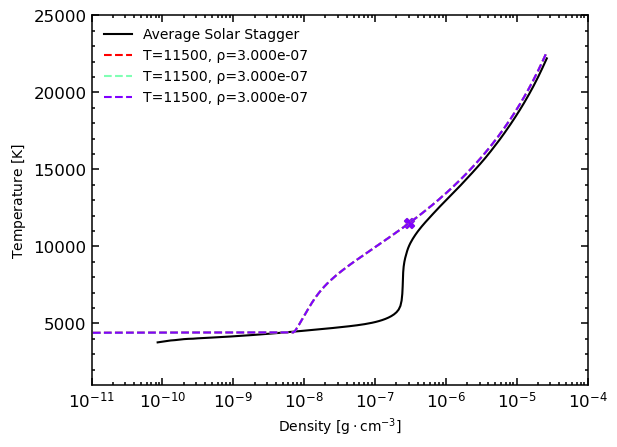

In [43]:
## Plotting
close()

f, ax = plt.subplots(1,1)
basic_plot!(ax)

# Curves
ax.plot(d_goal, T_goal, color="k",          label="Average Solar Stagger")

for i in eachindex(T_ini)
    d, t = adiabats[:d][i], adiabats[:t][i]
    ax.plot(d,      t,      color=color[i], ls="--", label="T=$(T_ini_s[i]), ρ=$(ρ_ini_s[i])")

    ## initial point
    ax.scatter([ρ_ini[i]], [T_ini[i]], color=color[i], marker="X", s=50)
end

## Setup
ax.set_xlim(1e-11, 1e-4)
ax.set_ylim(1000, 25000)

#plt.axvline(3e-7)


## labels
ax.set_xlabel(L"\rm Density\ [g \cdot cm^{-3}]")
ax.set_ylabel(L"\rm Temperature\ [K]")
ax.set_xscale("log")
ax.legend(framealpha=0);

gcf()

Profiles against geometrical depth

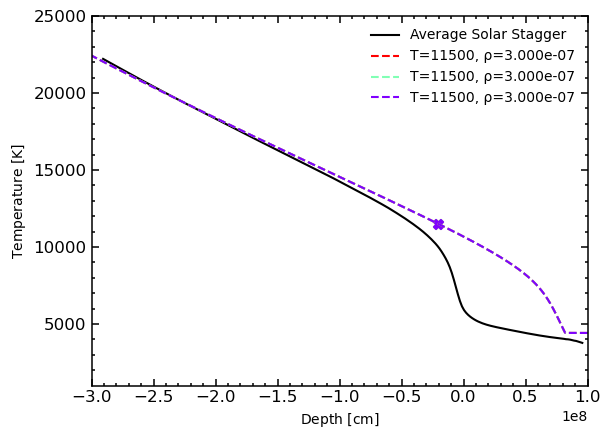

In [44]:
## Plotting
close()

f, ax = plt.subplots(1,1)
basic_plot!(ax)

# Curves
ax.plot(z_goal, T_goal, color="k",          label="Average Solar Stagger")

for i in eachindex(T_ini)
    z, t = adiabats[:z][i] .*1e8, adiabats[:t][i]
    ax.plot(z,      t,      color=color[i], ls="--", label="T=$(T_ini_s[i]), ρ=$(ρ_ini_s[i])")

    ## initial point
    ax.scatter([z0[i]*1e8], [T_ini[i]], color=color[i], marker="X", s=50)
end

## Setup
ax.set_xlim(-3e8, 1e8)
ax.set_ylim(1000, 25000)

#plt.axvline(3e-7)

## labels
ax.set_xlabel(L"\rm Depth\ [cm]")
ax.set_ylabel(L"\rm Temperature\ [K]")

ax.legend(framealpha=0);

gcf()

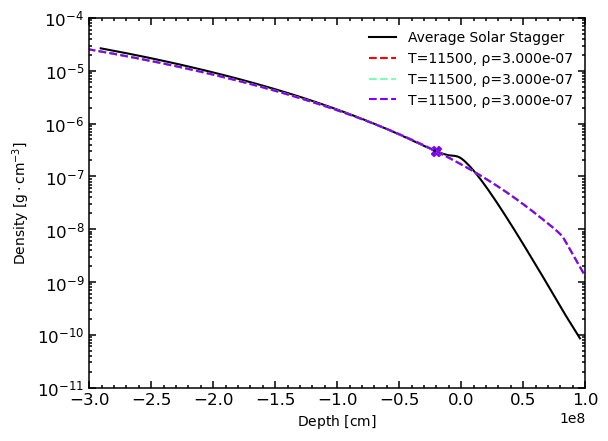

In [45]:
## Plotting
close()

f, ax = plt.subplots(1,1)
basic_plot!(ax)

# Curves
ax.plot(z_goal, d_goal, color="k",          label="Average Solar Stagger")

for i in eachindex(T_ini)
    z, t = adiabats[:z][i] .*1e8, adiabats[:d][i]
    ax.plot(z,      t,      color=color[i], ls="--", label="T=$(T_ini_s[i]), ρ=$(ρ_ini_s[i])")

    ## initial point
    ax.scatter([z0[i]*1e8], [ρ_ini[i]], color=color[i], marker="X", s=50)
end

## Setup
ax.set_xlim(-3e8, 1e8)
ax.set_ylim(1e-11, 1e-4)

#plt.axvline(3e-7)
#plt.axhline(10000)

## labels
ax.set_xlabel(L"\rm Depth\ [cm]")
ax.set_ylabel(L"\rm Density\ [g \cdot cm^{-3}]")
ax.set_yscale("log")
ax.legend(framealpha=0);

gcf()